In [90]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from queue import Queue
from scipy import ndimage

In [159]:
#加载数据
fpath1= "C:/Users/pc_207/Desktop/2023a_cm" + "/seg_nii/T2_3.nii.gz"
img = nib.load(fpath1)

#加载mask
fpath2= "C:/Users/pc_207/Desktop/2023a_cm" + "/seg_nii/T2_mask_3.nii"
mask = nib.load(fpath2)

#加载seg
fpath3= "C:/Users/pc_207/Desktop/2023a_cm" + "/seg_nii/T2_seg_mask_3.nii.gz"
seg_mask = nib.load(fpath3)

In [160]:
#获得分辨率基本信息
width,height,queue=img.dataobj.shape#img.dataobj.shape[0:3]
pixdim = img.header["pixdim"]
print( "shape:",width,height,queue,"pixdim:",pixdim[1],pixdim[2],pixdim[3])

ValueError: too many values to unpack (expected 3)

In [161]:
#获得边缘
def get_edge(edge,num,start,flag):
    temp=0
    num=num
    while temp==0:
        if flag == 0:
            temp = np.sum(edge[num,:,:])
        if flag == 1:
            temp = np.sum(edge[:,num,:])
        if flag == 2:
            temp = np.sum(edge[:,:,num])
        if start:
            num = num+1
        else:
            num = num-1
    if start:
        return num-1
    else:
        return num+1

e1 = get_edge(seg_mask.dataobj[:, :, :], 0, True,0)
e2 = get_edge(seg_mask.dataobj[:, :, :], 256-1, False,0)
e3 = get_edge(seg_mask.dataobj[:, :, :], 0, True,1)
e4 = get_edge(seg_mask.dataobj[:, :, :], 256-1, False,1)
e5 = get_edge(seg_mask.dataobj[:, :, :], 0, True,2)
e6 = get_edge(seg_mask.dataobj[:, :, :], 192-1, False,2)

In [162]:
#获得数据(注意这里是需要保留相应部分的小块，把脑干包含进去就可以)
len_x,len_y,len_z = e2-e1,e4-e3,e6-e5
print(len_x,len_y,len_z)

img_arr = img.dataobj[e1:e2, e3:e4, e5:e6]#[:,:,:,0,0]
mask_arr = mask.dataobj[e1:e2, e3:e4, e5:e6]
seg_mask_arr = seg_mask.dataobj[e1:e2, e3:e4, e5:e6]/2

#先减去再生长
img_arr = img_arr*(1-mask_arr)

42 41 40


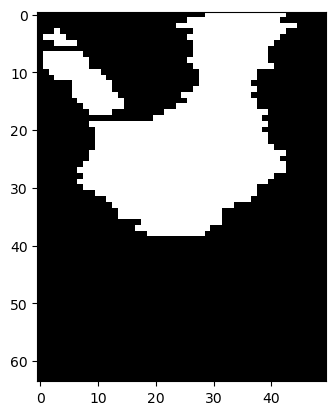

In [54]:
#plt.imshow(seg_mask_arr[15,:,:],cmap="gray")

In [163]:
#写一个生长函数，把array扔进去得到新的array
def grow_seg(image, seed, threshold,th2=0.5):
                            
    height, width, depth = image.shape
    segmented = np.zeros_like(image)
    visited = np.zeros_like(image)
    
    q = Queue()
    q.put(seed)
    region_sum = 0
    region_size = 0
    
    while not q.empty():
        current = q.get()
        x, y, z = current
        if visited[x, y, z]:
            continue
        
        visited[x, y, z] = 1
        if np.abs(image[x, y, z] - image[seed]) <= threshold:
            segmented[x, y, z] = 1
            region_sum += image[x, y, z]
            region_size += 1
            
            for i in range(-1, 2):
                for j in range(-1, 2):
                    for k in range(-1, 2):
                        if 0 <= x+i < height and 0 <= y+j < width and 0 <= z+k < depth:
                            if np.abs(image[x+i, y+j, z+k] - image[x, y, z]) <= 0.02:#这里是我后加的
                                q.put((x+i, y+j, z+k))
                                
    #每个切面连通
    for i in range(segmented.shape[2]):
        image = segmented[:,:,i]
        labeled_image, num_features = ndimage.label(image)

        # 计算每个连通分量的大小
        sizes = ndimage.sum(image, labeled_image, range(1, num_features + 1))

        # 找到体积最大的连通分量的标签
        max_label = np.argmax(sizes) + 1

        # 提取体积最大的连通分量
        largest_component = (labeled_image == max_label).astype(np.uint8)
        segmented[:,:,i] = largest_component
    for i in range(segmented.shape[0]):
        image = segmented[i,:,:]
        labeled_image, num_features = ndimage.label(image)

        # 计算每个连通分量的大小
        sizes = ndimage.sum(image, labeled_image, range(1, num_features + 1))

        # 找到体积最大的连通分量的标签
        max_label = np.argmax(sizes) + 1

        # 提取体积最大的连通分量
        largest_component = (labeled_image == max_label).astype(np.uint8)
        segmented[i,:,:] = largest_component
    for i in range(segmented.shape[1]):
        image = segmented[:,i,:]
        labeled_image, num_features = ndimage.label(image)

        # 计算每个连通分量的大小
        sizes = ndimage.sum(image, labeled_image, range(1, num_features + 1))

        # 找到体积最大的连通分量的标签
        max_label = np.argmax(sizes) + 1

        # 提取体积最大的连通分量
        largest_component = (labeled_image == max_label).astype(np.uint8)
        segmented[:,i,:] = largest_component
    
    return segmented
    """
    # 确保区域连通
    image = segmented

    # 使用连通分量算法获取连通区域
    labeled_image, num_features = ndimage.label(image)

    # 计算每个连通分量的大小
    sizes = ndimage.sum(image, labeled_image, range(1, num_features + 1))

    # 找到体积最大的连通分量的标签
    max_label = np.argmax(sizes) + 1

    # 提取体积最大的连通分量
    largest_component = (labeled_image == max_label).astype(np.uint8)
    
    
    #return largest_component"""

#img_arr 应该先归一化，不然数太大
img_arr = img_arr-np.min(img_arr)
img_arr = img_arr/np.max(img_arr)
seg_arr = grow_seg(img_arr,(int(len_x/2),int(len_y/2),int(len_z/2)),0.1)

误差： 0.3076923076923077


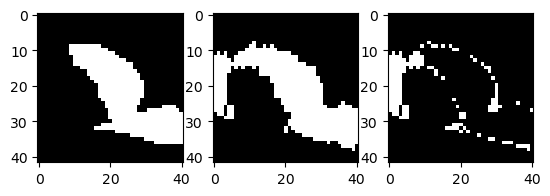

In [164]:
#与分割结果进行比较 可视化
import matplotlib.pyplot as plt

tp1 = seg_arr[:,:,int(len_z/2)]
tp2 = seg_mask_arr[:,:,int(len_z/2)]
tp3 = np.abs(tp1-tp2)

#分割结果
plt.subplot(1,3,1)
plt.imshow(tp1,cmap="gray")
#实际标签
plt.subplot(1,3,2)
plt.imshow(tp2,cmap="gray")
#做差比较
plt.subplot(1,3,3)
plt.imshow(tp3,cmap="gray")

print("误差：",np.sum(tp3)/np.sum(tp2))

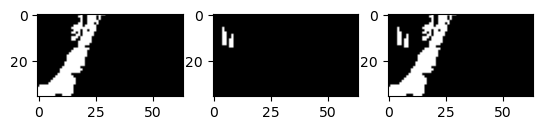

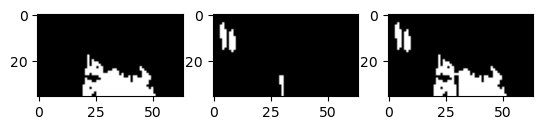

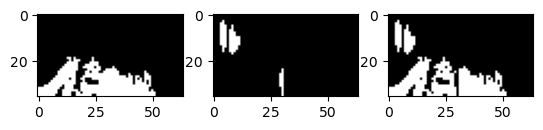

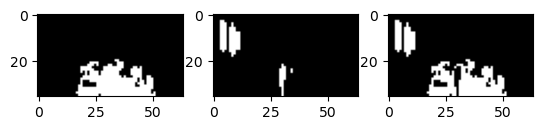

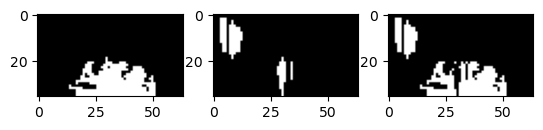

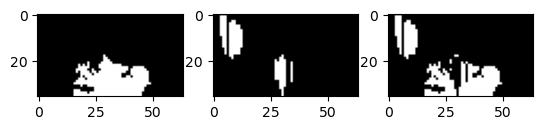

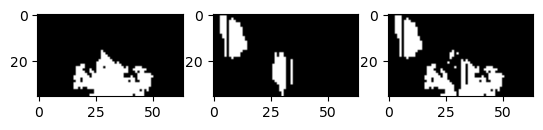

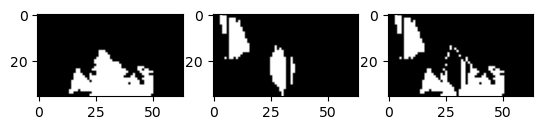

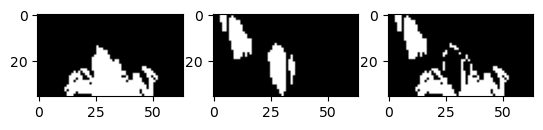

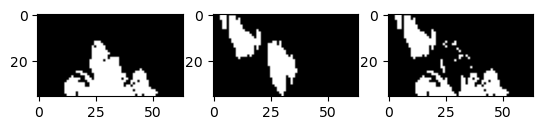

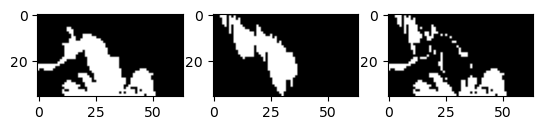

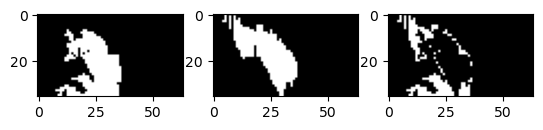

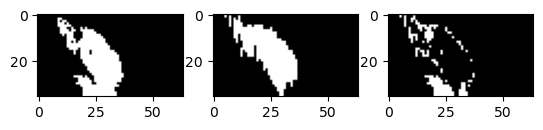

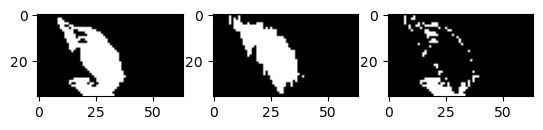

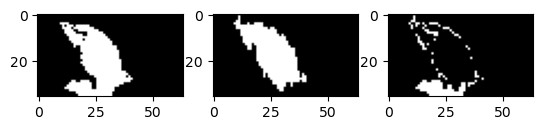

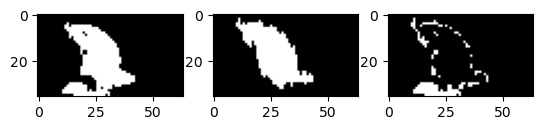

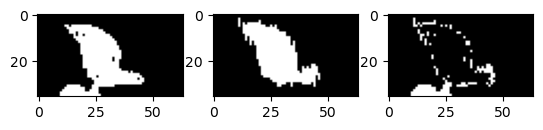

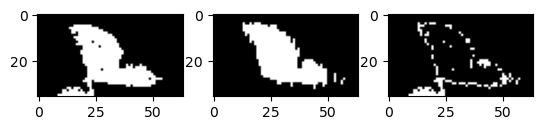

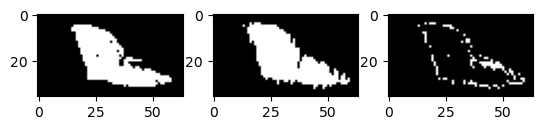

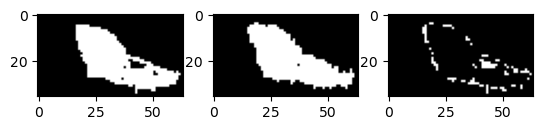

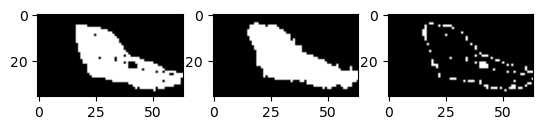

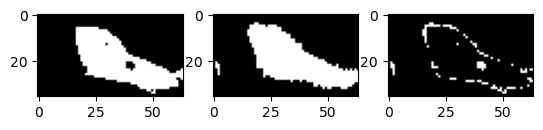

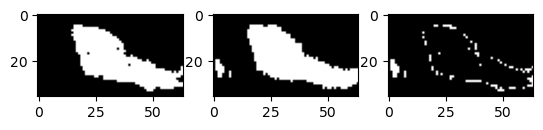

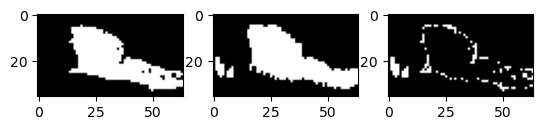

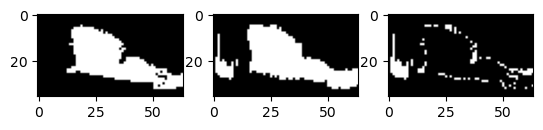

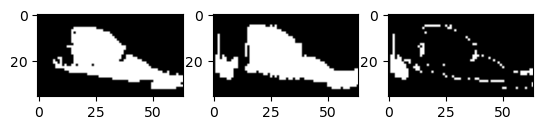

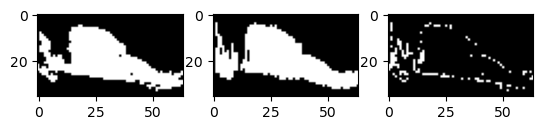

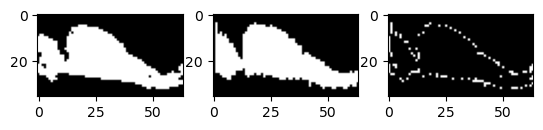

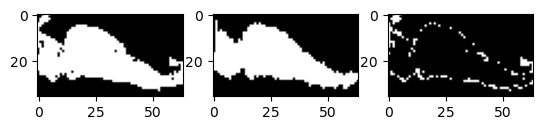

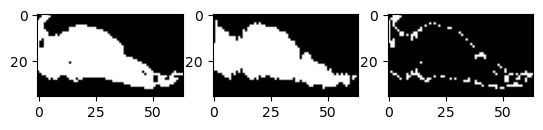

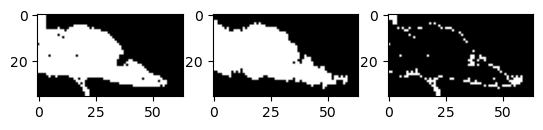

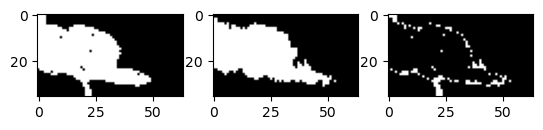

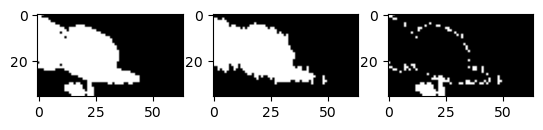

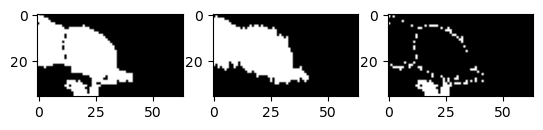

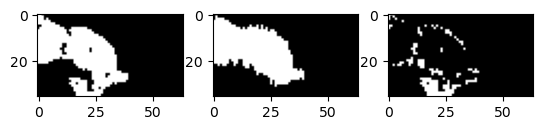

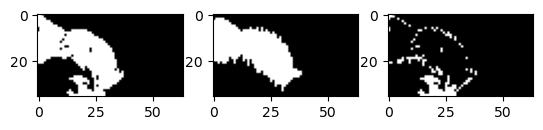

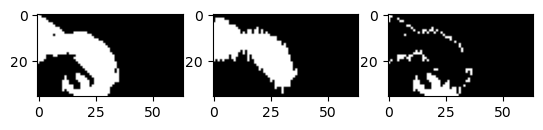

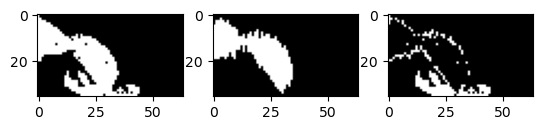

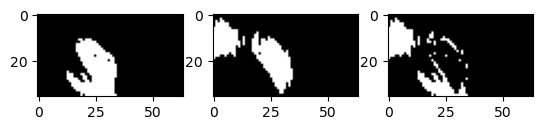

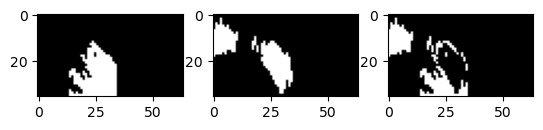

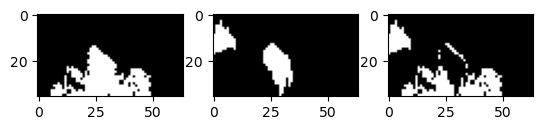

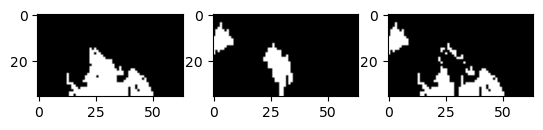

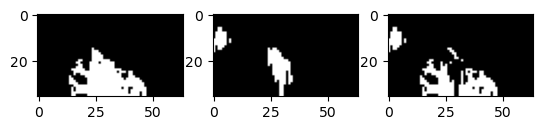

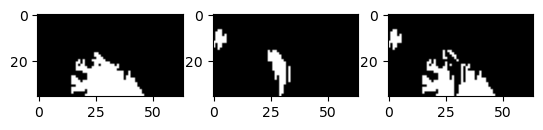

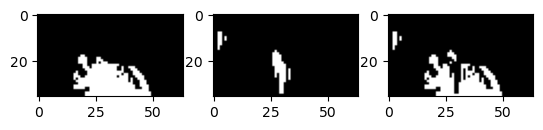

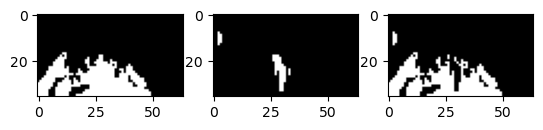

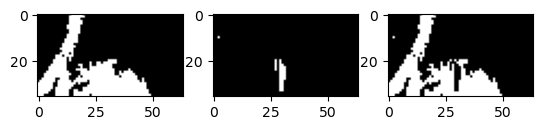

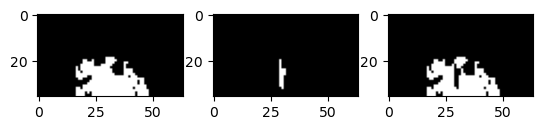

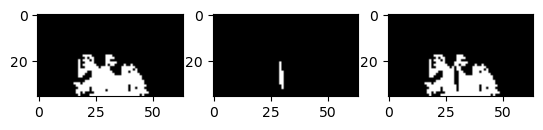

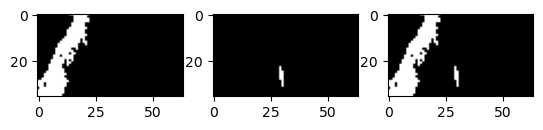

In [147]:
for i in range(len_z):
    #分割结果
    plt.subplot(1,3,1)
    plt.imshow(seg_arr[:,:,i],cmap="gray")
    #实际标签
    plt.subplot(1,3,2)
    plt.imshow(seg_mask_arr[:,:,i],cmap="gray")
    #做差比较
    plt.subplot(1,3,3)
    plt.imshow( np.abs(seg_arr[:,:,i]-seg_mask_arr[:,:,i]),cmap="gray")
    plt.show()
    input()

In [166]:
data  = np.zeros_like(img.dataobj[:, :, :])
data[e1:e2, e3:e4, e5:e6] = seg_arr
new_img = nib.Nifti1Image(data, img.affine)

nib.save(new_img, "./seg_nii/T2_seg_3.nii.gz")

In [12]:
a = np.array([[1,2,3],[4,5,6]])
b = np.array([[0,1,0],[1,0,1]])

3

In [88]:
import numpy as np
from scipy import ndimage

# 创建示例图像数据
image = seg_arr

# 使用连通分量算法获取连通区域
labeled_image, num_features = ndimage.label(image)

# 计算每个连通分量的大小
sizes = ndimage.sum(image, labeled_image, range(1, num_features + 1))

# 找到体积最大的连通分量的标签
max_label = np.argmax(sizes) + 1

# 提取体积最大的连通分量
largest_component = (labeled_image == max_label).astype(np.uint8)

print("Largest component:")
print(largest_component)

Largest component:
[[[1 1 1 ... 1 1 1]
  [0 0 1 ... 1 0 0]
  [0 0 0 ... 1 1 1]
  ...
  [1 1 1 ... 0 0 0]
  [1 1 1 ... 0 0 0]
  [1 1 1 ... 0 0 0]]

 [[1 1 1 ... 0 1 1]
  [1 0 0 ... 1 1 1]
  [0 0 0 ... 1 1 1]
  ...
  [1 0 0 ... 0 0 0]
  [1 0 0 ... 0 0 0]
  [1 0 0 ... 0 0 0]]

 [[1 1 0 ... 0 0 1]
  [1 0 0 ... 1 1 1]
  [0 0 0 ... 1 1 1]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [1 0 0 ... 0 0 0]]

 ...

 [[1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  ...
  [0 0 1 ... 0 0 0]
  [0 0 1 ... 0 0 0]
  [0 0 1 ... 0 0 0]]

 [[1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  ...
  [0 0 1 ... 0 0 0]
  [1 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  ...
  [0 0 1 ... 0 0 0]
  [1 1 1 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
